In [1]:
#!/bin/python3 

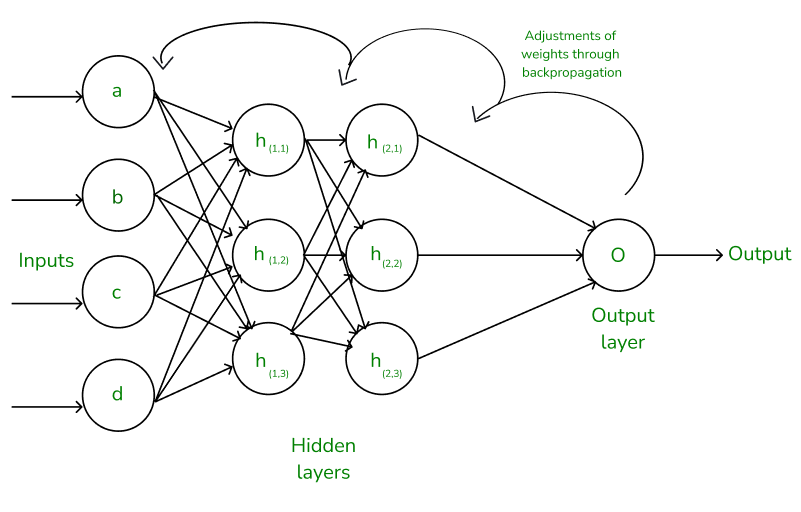

### Now we are creating an object for NN

In [2]:
import matplotlib.pyplot as plt
from graphviz import Digraph
import math
import random

In [3]:
class value:# first we have to inizilize a class which will turn the variable or numbers into an object so that we can do chnages to them
    def __init__(self,data,_children=(),operation="",label=""):
        self.data = data
        self._prev=set(_children)
        self.operation=operation
        self.label=label
        self.grad =0.0
        self._back= lambda:None  # here we are initializing a None lambda function so that we can backpropagate from the input to the "How we get to this input " 
        
    def __repr__(self):# returns just the string 
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,value) else value(other)
        out = value(self.data+other.data,(self,other),"+")
        def _back():
            self.grad += 1*out.grad
            other.grad +=1*out.grad
        out._back=_back
        return out
    
    def __neg__(self):
        return value(-self.data, (self,), "-")
    
    def __sub__(self,other):
        other = other if isinstance(other, value) else value(other)
        out = self + (-other)

        def _back():
            self.grad += 1 * out.grad
            other.grad += -1 * out.grad
        out._back = _back
        return out
        
    
    def __mul__(self,other):
        other = other if isinstance(other,value) else value(other)
        out = value(self.data * other.data,(self,other),"*")
        def _back():
            self.grad += other.data*out.grad
            other.grad +=self.data*out.grad
        out._back=_back
        return out
    
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out =value(self.data**other,(self,),f'**{other}')
        def _back():
            self.grad += other*self.data**(other-1)*out.grad
        out._back=_back
        return out
            
    def __rmul__(self,other):
        return self*other
    
    def __truediv__(self,other):
        other = other if isinstance(other, value) else value(other)
        out = value(self.data*other.data**-1, (self, other), "/")
        def _back():
            self.grad += (1 / other.data) * out.grad  
            other.grad += (-self.data / other.data**2) * out.grad
        out._back = _back
        return out
    
    def exp(self):
        x =self.data
        out=value(math.exp(x),(self,),"exp")
        def _back():
            self.grad += out.data*out.grad
        out._back=_back
        return out
        
    def tanh(self):
        x=self.data
        t =(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = value(t,(self,),"tanh")
        def _back():
            self.grad += (1-t**2)*out.grad
        out._back=_back
        return out
    def _backward(self):
        #Topoliogical sort for backpropagrtion
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1
        for node in reversed(topo):
            node._back()


In [4]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    if isinstance(root, list):
        for v in root:
            build(v)
    else:
        build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s |data %.4f|grad %.4f  }" % (n.label,n.data,n.grad), shape='record')
        if n.operation:
            dot.node(name=str(id(n)) + n.operation, label=n.operation)
            dot.edge(str(id(n)) + n.operation, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.operation)

    return dot

In [5]:
#Making single layer perceptron
#data points 
x1 = value(2.0,label="x1")
x2 = value(0.0,label="x2")

#Weights of the perceptron
w1 = value(-3.0,label="w1")
w2 = value(1.0,label="w2")

#bias of the perceptron
b = value(6.8813735870195431,label="b")

#x1*w1+x2*w2+b
x1w1=x1*w1;x1w1.label="x1w1"
x2w2=x2*w2;x2w2.label="x2w2"
x1w1x2w2=x1w1+x2w2;x1w1x2w2.label="x1w1+x2w2"
x1w1x2w2_b=x1w1x2w2+b;x1w1x2w2_b.label="x1w1+x2w2+b"
k =(x1w1x2w2_b*2).exp() #for tanh fucntion
o = (k-1)/(k+1)
o.label="output"


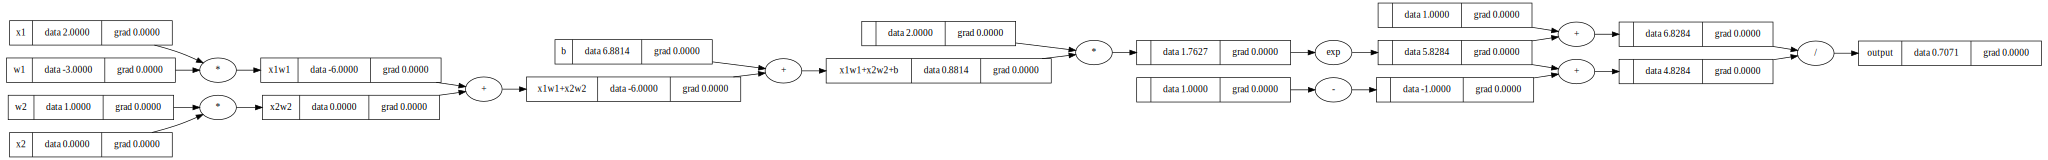

In [6]:
draw_dot(o)

In [7]:
o._backward()

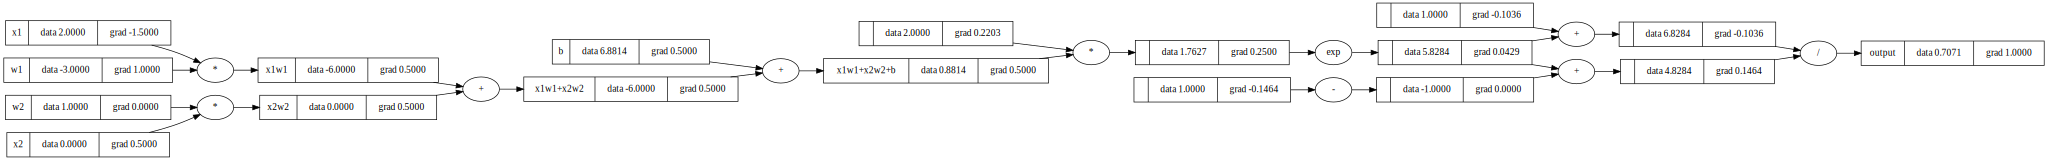

In [8]:
draw_dot(o)

In [9]:
#creating a neural network
random.seed(5)

# this is one percertron of neural network
class Neuron:
    def __init__(self,no_of_input):
        self.weight = [value(random.uniform(-1,1)) for _ in range(no_of_input) ]# creating some temporary data
        self.bias= value(random.uniform(-1,1))
    def __call__(self,x):
        #what we are trying to do is w*x+b
        act = sum((xi*wi for xi,wi in list(zip(x,self.weight))),self.bias)
        k = (act*2).exp() # for tanh
        out = (k+1)/(k-1)
        return out
    def parameters(self):
        return self.weight+[self.bias]
    
# this is the no of neurons in one layer of neural netowrk 
class layers:
    def __init__(self,no_of_input,no_of_neurons_in_a_layer):
        self.neurons_layer = [Neuron(no_of_input) for _ in range(no_of_neurons_in_a_layer)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons_layer]
        return outs
    def parameters(self):
        params = []
        for neuron in self.neurons_layer:
            ps =neuron.parameters()
            params.extend(ps)
        return params
    
# now its time to make the layers of neural network
class MLP:
    def __init__(self,no_of_input,set_of_neurons_in_each_layer):
        k = [no_of_input]+set_of_neurons_in_each_layer
        self.layer = [layers(k[i],k[i+1]) for i in range(len(set_of_neurons_in_each_layer))]
        
    def __call__(self,x):
        for l in self.layer:
            x = l(x)
        return x
    
    def parameters(self):
        params=[]
        for layer in self.layer:
            ps =layer.parameters()
            params.extend(ps)
        return params
    


In [10]:
x = [2.0,3.4,1.6]
n = MLP(3,[6,4,5,1])
n(x)

[Value(data=-1.0467137299124472)]

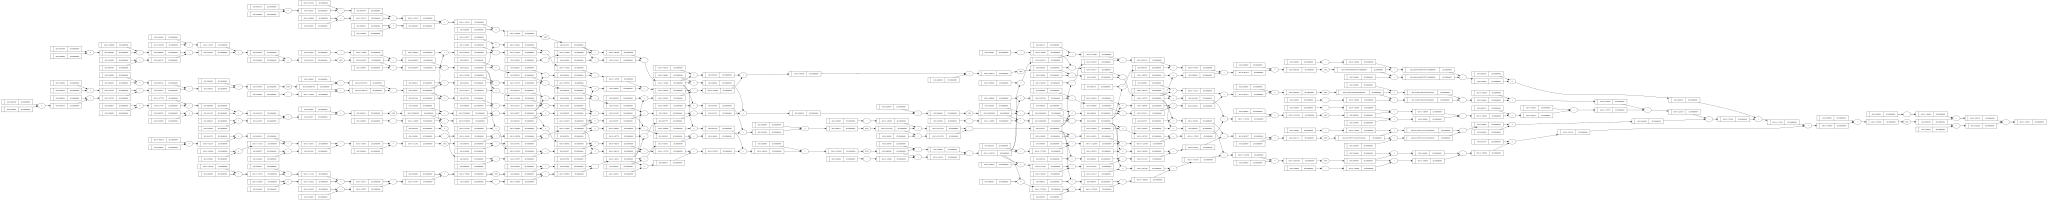

In [11]:
draw_dot(n(x))

In [12]:
# lets try to a multi input data neural net

xs = [[value(1.12), value(3.2), value(0.21)],
      [value(2.1), value(6.2), value(2.1)],
      [value(4.2), value(6.2), value(2.5)]]

ys = [value(-1.0), value(-1.0), value(1.0)]# desired targets
k = MLP(3,[4,4,1])
y_pred = [k(x) for x in xs]
y_pred = [out[0] for out in y_pred]
y_pred


[Value(data=-1.1972744081821696),
 Value(data=-1.000000151683388),
 Value(data=-1.000004136966869)]

In [13]:
loss = sum([(pred - real) ** 2 for pred, real in zip(y_pred, ys)], value(0))
loss

Value(data=4.038933740008239)

In [14]:
n.layer[0].neurons_layer[0].weight[0].grad

0.0

In [15]:
loss._backward()

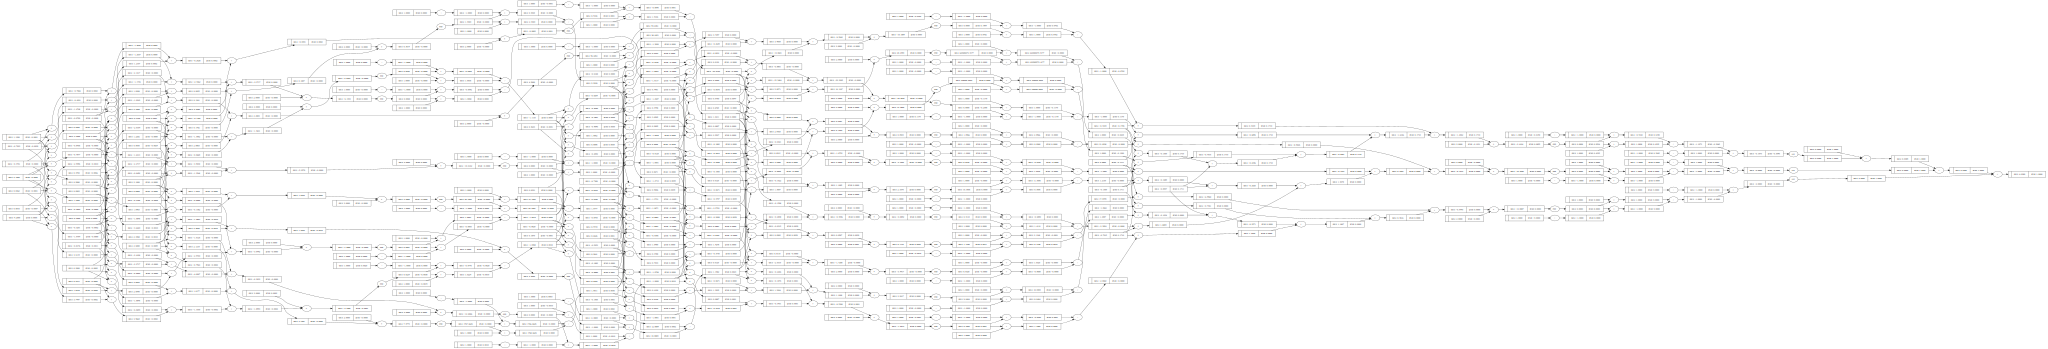

In [16]:
 draw_dot(loss)

In [17]:
len(n.parameters())# all the paramaneters inluding weights and biases

83

In [18]:
xs = [[value(1.12), value(3.2), value(0.21)],
      [value(2.1), value(6.2), value(2.1)],
      [value(4.2), value(6.2), value(2.5)]]

ys = [value(-1.0), value(-1.0), value(1.0)]# desired targets
l= MLP(3,[4,3,4,1])

In [20]:

for k in range(100):
    #forward pass
    y_pred = [l(x) for x in xs]
    y_pred = [out[0] for out in y_pred]
    loss = sum([(pred - real)** 2 for pred, real in zip(y_pred, ys)], value(0))
    
    #backward pass
    loss._backward()
    
    #update
    for p in l.parameters():
        p.data += -0.1*p.grad
    for p in l.parameters():
        p.grad=0.0
    print(loss.data)


8.00000015148287
8.000000153612776
8.000000155794718
8.00000015803051
8.000000160322049
8.00000016267131
8.000000165080369
8.000000167551395
8.000000170086665
8.000000172688555
8.000000175359563
8.000000178102304
8.000000180919525
8.000000183814116
8.000000186789096
8.000000189847652
8.000000192993136
8.000000196229065
8.000000199559146
8.000000202987293
8.00000020651761
8.000000210154456
8.000000213902402
8.000000217766292
8.00000022175124
8.000000225862655
8.000000230106261
8.000000234488118
8.000000239014652
8.000000243692671
8.000000248529414
8.000000253532559
8.000000258710266
8.000000264071232
8.000000269624705
8.000000275380552
8.000000281349285
8.000000287542145
8.000000293971143
8.000000300649118
8.000000307589842
8.00000031480806
8.000000322319611
8.000000330141505
8.00000033829205
8.000000346790957
8.000000355659486
8.000000364920586
8.000000374599074
8.000000384721817
8.00000039531794
8.00000040641906
8.000000418059564
8.000000430276902
8.000000443111915
8.00000045660924
8.